In [22]:
# Core
import os, pathlib, warnings, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reporting
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
warnings.filterwarnings('ignore')

import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0"


print("TensorFlow version:", tf.__version__)



TensorFlow version: 2.18.0


In [2]:
# 🗂️  Adjust the path to your dataset root
DATASET_PATH = "/kaggle/input/tea-leaves/tea sickness dataset"
dataset_dir  = pathlib.Path(DATASET_PATH)

# Discover classes from sub-folders
class_names = sorted([p.name for p in dataset_dir.iterdir() if p.is_dir()])
print(f"Detected classes ({len(class_names)}): {class_names}\n")

# Count images per class
def count_images_per_class(root):
    return {c.name: len(list(c.glob("*.jpg"))) for c in root.iterdir() if c.is_dir()}

class_counts = count_images_per_class(dataset_dir)
display(pd.Series(class_counts, name="images").sort_values(ascending=False))
print("Total images:", sum(class_counts.values()))


Detected classes (8): ['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']



red leaf spot    143
white spot       142
brown blight     113
algal leaf       113
Anthracnose      100
bird eye spot    100
gray light       100
healthy           74
Name: images, dtype: int64

Total images: 885


In [3]:
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
VAL_SPLIT   = 0.20
SEED        = 123
EPOCHS_HEAD = 100   # head training
EPOCHS_FINE = 100    # fine-tuning
num_classes = len(class_names)


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

# ⚠️  Store BEFORE cache/prefetch so the object still has the attribute
class_names = train_ds.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = (train_ds.shuffle(1000)
                    .cache()
                    .prefetch(buffer_size=AUTOTUNE))
val_ds   = (val_ds.cache()
                    .prefetch(buffer_size=AUTOTUNE))


Found 885 files belonging to 8 classes.
Using 708 files for training.


I0000 00:00:1752050714.337095      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 885 files belonging to 8 classes.
Using 177 files for validation.


In [5]:
# ---------- 5  CLASS WEIGHTS (safe version) ----------
labels_int = []
for cls, n in class_counts.items():
    idx = class_names.index(cls)
    labels_int.extend([idx] * n)

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=labels_int)

# ⚠️ Cast NumPy scalars to builtin float
class_weight = {i: float(w) for i, w in enumerate(weights)}
print("Class-weight mapping:", class_weight)


Class-weight mapping: {0: 1.10625, 1: 0.9789823008849557, 2: 1.10625, 3: 0.9789823008849557, 4: 1.10625, 5: 1.4949324324324325, 6: 0.7736013986013986, 7: 0.7790492957746479}


In [6]:
train_raw = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)


Found 885 files belonging to 8 classes.
Using 708 files for training.
Found 885 files belonging to 8 classes.
Using 177 files for validation.


In [7]:
weight_lut = tf.constant([class_weight[i] for i in range(num_classes)],
                         dtype=tf.float32)

def add_weight(img, label):
    return img, label, tf.gather(weight_lut, label)   # (x, y, w)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = (train_raw
            .map(add_weight, num_parallel_calls=AUTOTUNE)
            .shuffle(1000)
            .cache()
            .prefetch(AUTOTUNE))

val_ds = (val_ds.cache().prefetch(AUTOTUNE))   # val: (x, y)


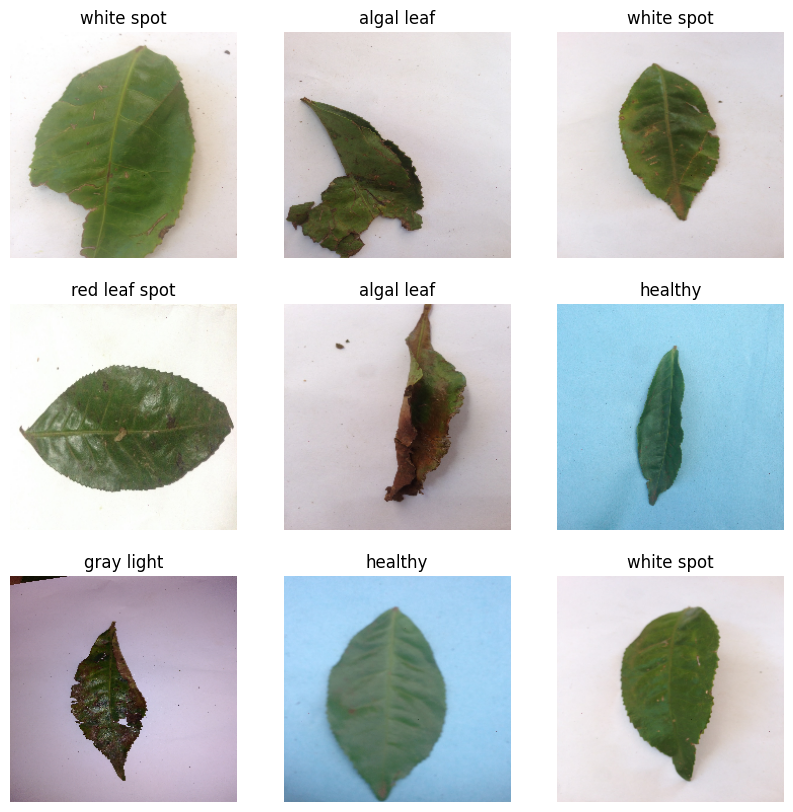

In [8]:
plt.figure(figsize=(10,10))
for imgs, labels, _ in train_ds.take(1):          # note the extra weight output
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(imgs[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


In [9]:
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25, fill_mode='reflect'),
    layers.RandomZoom(0.25),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])


In [10]:
base = tf.keras.applications.EfficientNetB0(include_top=False,
                                            weights="imagenet",
                                            input_shape=IMG_SIZE + (3,))
base.trainable = False

inputs  = keras.Input(shape=IMG_SIZE + (3,))
x       = data_aug(inputs)
x       = tf.keras.applications.efficientnet.preprocess_input(x)
x       = base(x, training=False)
x       = layers.GlobalAveragePooling2D()(x)
x       = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [12]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "best_tealeaf.h5", monitor="val_accuracy",
    mode="max", save_best_only=True, verbose=1)

earlystop  = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", mode="max",
    patience=5, restore_best_weights=True)

lr_reduce  = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2,
    patience=3, verbose=1)


In [13]:
# ---------- 11-A  filter callbacks that deep-copy cleanly ----------
import copy
callbacks_all = [checkpoint, earlystop, lr_reduce]
safe_cbs = []
for cb in callbacks_all:
    try:
        copy.deepcopy(cb)
        safe_cbs.append(cb)
    except Exception as e:
        print(f"{cb.__class__.__name__} removed – deepcopy fails")

# ---------- 11-B  add lightweight LR scheduler if needed ----------
if not any(isinstance(cb, keras.callbacks.ReduceLROnPlateau) for cb in safe_cbs):
    class SimpleLRScheduler(keras.callbacks.Callback):
        def __init__(self, factor=0.5, step=3, min_lr=1e-6):
            self.factor, self.step, self.min_lr = factor, step, min_lr
        def on_epoch_begin(self, epoch, logs=None):
            if epoch and epoch % self.step == 0:
                lr = keras.backend.get_value(self.model.optimizer.lr)
                new_lr = max(lr * self.factor, self.min_lr)
                keras.backend.set_value(self.model.optimizer.lr, new_lr)
                print(f"\nEpoch {epoch}: LR -> {new_lr:.2e}")
    safe_cbs.append(SimpleLRScheduler())


In [14]:
# REMOVE ALL CALLBACKS
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD)


Epoch 1/100


E0000 00:00:1752050744.325590      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1752050755.614966     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 356ms/step - accuracy: 0.1892 - loss: 2.0192 - val_accuracy: 0.3842 - val_loss: 1.7149
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4569 - loss: 1.4562 - val_accuracy: 0.4746 - val_loss: 1.4300
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6319 - loss: 1.1869 - val_accuracy: 0.5311 - val_loss: 1.3043
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6800 - loss: 1.0152 - val_accuracy: 0.5593 - val_loss: 1.2005
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6933 - loss: 0.9387 - val_accuracy: 0.5593 - val_loss: 1.1684
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7028 - loss: 0.8606 - val_accuracy: 0.5763 - val_loss: 1.1088
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7524 - loss: 0.8133 - val_accuracy: 0.6045 - val_loss: 1.0496
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7354 - loss: 0.7496 - val_accuracy: 0.6215 - val

In [15]:
# 13 Fine-tune EfficientNet top layers
base.trainable = True
fine_tune_at = 200                      # freeze earlier layers
for layer in base.layers[:fine_tune_at]:
    layer.trainable = False

# Define new optimizer with lower LR
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

# Re-compile with new optimizer
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD + EPOCHS_FINE,
    initial_epoch=history_head.epoch[-1])


Epoch 100/200


E0000 00:00:1752050913.291305      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 252ms/step - accuracy: 0.7532 - loss: 0.6436 - val_accuracy: 0.7627 - val_loss: 0.6754
Epoch 101/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8229 - loss: 0.4821 - val_accuracy: 0.7853 - val_loss: 0.6439
Epoch 102/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8397 - loss: 0.4101 - val_accuracy: 0.7853 - val_loss: 0.6190
Epoch 103/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8543 - loss: 0.4195 - val_accuracy: 0.8023 - val_loss: 0.6103
Epoch 104/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8838 - loss: 0.3060 - val_accuracy: 0.8023 - val_loss: 0.6116
Epoch 105/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8730 - loss: 0.3203 - val_accuracy: 0.8192 - val_loss: 0.5736
Epoch 106/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8849 - loss: 0.3126 - val_accuracy: 0.8305 - val_loss: 0.5643
Epoch 107/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9051 - loss: 0.2653 - val_accuracy

In [24]:
# Save the fine-tuned model in the new Keras v3 format
model.save("best_tealeaf.keras")          # <- single file, no pickle bug
print("✅ Model saved → best_tealeaf.keras")


✅ Model saved → best_tealeaf.keras


In [25]:
import tensorflow as tf
# Disable XLA JIT to avoid UnsupportedOp errors on GPU
tf.config.optimizer.set_jit(False)

loaded_model = tf.keras.models.load_model("best_tealeaf.keras", compile=False)
print("✅ Model re-loaded for inference")

✅ Model re-loaded for inference


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


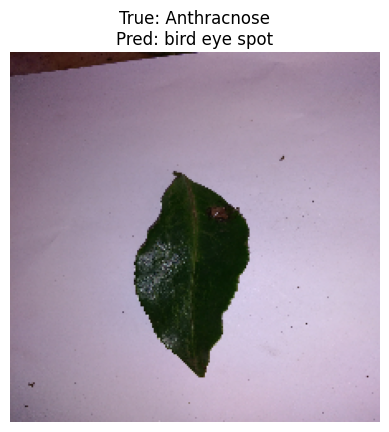

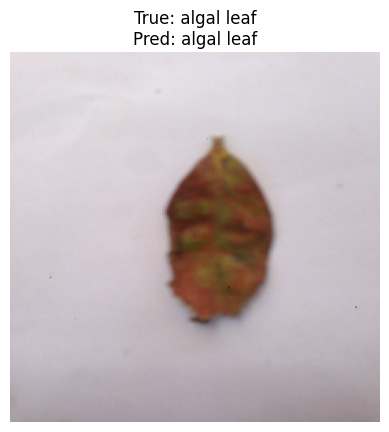

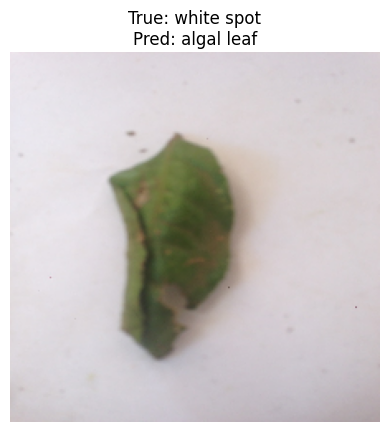

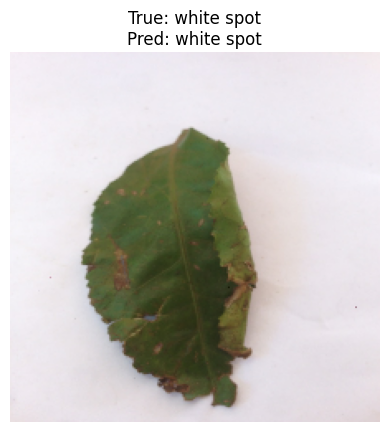

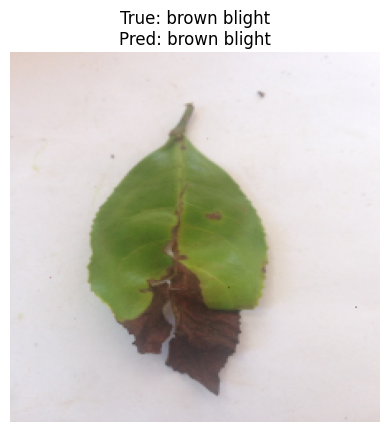

In [26]:
import numpy as np
import matplotlib.pyplot as plt

for images, labels in val_ds.take(1):
    preds = loaded_model.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = labels.numpy()

    for i in range(5):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[pred_classes[i]]}")
        plt.axis("off")
        plt.show()


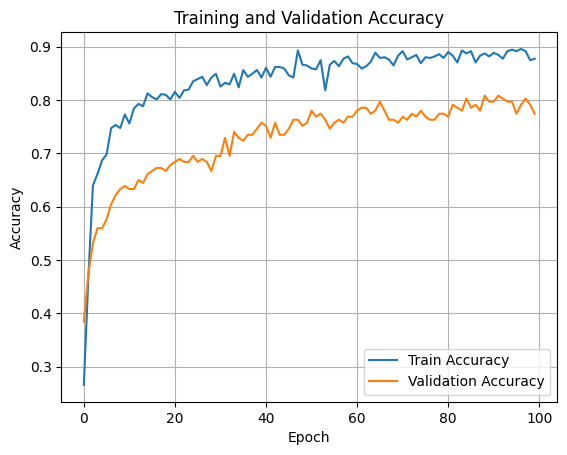

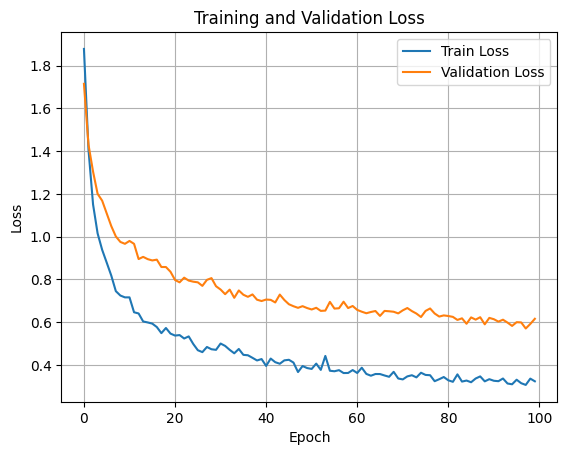

In [27]:
import matplotlib.pyplot as plt

# Plot training vs validation accuracy
plt.plot(history_head.history['accuracy'], label='Train Accuracy')
plt.plot(history_head.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training vs validation loss
plt.plot(history_head.history['loss'], label='Train Loss')
plt.plot(history_head.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# Evaluate final model on validation data
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8681 - loss: 0.4804
Validation Accuracy: 0.8588
Validation Loss: 0.5315


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
               precision    recall  f1-score   support

  Anthracnose       0.84      0.64      0.73        25
   algal leaf       0.81      0.85      0.83        20
bird eye spot       0.76      0.76      0.76        17
 brown blight       0.96      0.87      0.91        30
   gray light       0.74      0.92      0.82        25
      healthy       1.00      1.00      1.00        14
red leaf spot       1.00      1.00      1.00        19
   white spot       0.83      0.89      0.86        27

     accuracy                           0.86       177
    macro avg       0.87      0.87      0.86       177
 weighted avg       0.86      0.86      0.86       177



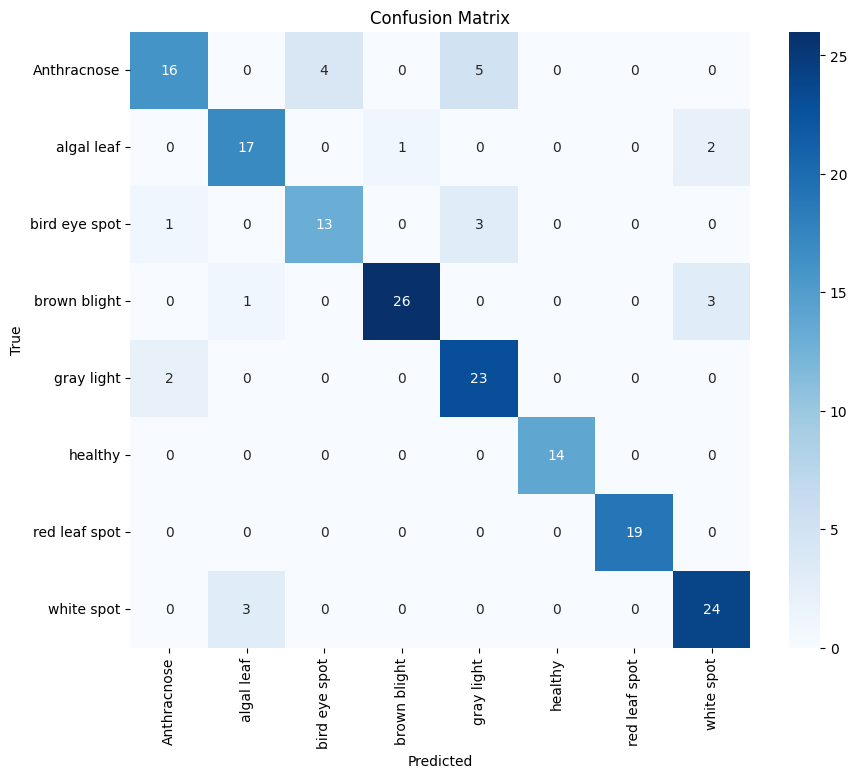

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Collect predictions on the whole val set
y_true, y_pred = [], []
for batch_x, batch_y in val_ds:
    batch_pred = loaded_model.predict(batch_x)
    y_pred.extend(np.argmax(batch_pred, axis=1))
    y_true.extend(batch_y.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()
